In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Classe Log que envelopa as informações sorbe detecções

In [ ]:
class Log:
    def __init__(self,x,y,r,c,a):
        self._x = [x]
        self._y = [y]
        self._r = [r]
        self.c = [c]
        self.a = [a] 
        self.q = c*0.1+a*0.9
        self.x = x
        self.y = y
        self.r = r
        self.counts = 1
        
        

## Funções para plotar os circulos

In [ ]:
def create_plot(title = "minimapa"):
    plt.figure(figsize = (12,9))
    plt.grid()
    plt.xlim(-0.4,3)
    plt.ylim(-0.5,2)
    plt.title(title,fontsize=20)


def plot_circle(x,y,r,c='b'):
    x_c = r*np.cos( np.linspace(-np.pi,np.pi))+x
    y_c = r*np.sin( np.linspace(-np.pi,np.pi))+y
    plt.plot(x_c,y_c,c=c)
    

    
def show(logs,c = "b"):
    for log in logs:
        plt.scatter(log.x,log.y,c='black')
        plot_circle(log.x,log.y,log.r,c = c)

## Função para gerar as toras aleatóriamente

In [ ]:
def generate(N = 4):
    x = np.random.rand(N)*3
    y = np.random.rand(N)*1.6
    r = 0.2 + np.random.rand(N)/7
    c = 0.85 + (np.random.rand(N)-0.5)/7
    a = 0.6 + (np.random.rand(N)-0.5)
    return x,y,r,c,a

## Criação de uma lista de objetos tora

In [ ]:
def generate_log_list(N = 4):
    logs = []
    x,y,r,c,a = generate(N)
    for x_,y_,r_,c_,a_ in zip(x,y,r,c,a):
        logs.append(Log(x_,y_,r_,c_,a_))
    return logs

## Cálculo das distâncias NxN 
criação de um indice a partir das distâncias e raios:

dists[i,j] / (logs[i].r+logs[j].r)

In [ ]:
def distances(logs):
    N = len(logs)
    dists = np.zeros((N,N))
    index = np.zeros((N,N))
    for i in range(N ):
        for j in range(N ):
            dists[i,j]     = ((logs[i].x-logs[j].x)**2+(logs[i].y-logs[j].y)**2)**0.5
            distance_index = (dists[i,j]/(logs[i].r+logs[j].r))
            index[i,j]     = distance_index if distance_index > 0 else 2
    return index

In [ ]:
def show_collisions(logs,index):
    for i in range(len(logs)):
        for j in range(len(logs)):
            if index[i,j]<1:
                plt.plot([logs[i].x,logs[j].x],[logs[i].y,logs[j].y],c='r')

## Fusão das detecções



In [ ]:
def fuse(i,j,logs,show = True):
    nx = (logs[i].x*logs[i].q+logs[j].x*logs[j].q)/(logs[i].q+logs[j].q)
    ny = (logs[i].y*logs[i].q+logs[j].y*logs[j].q)/(logs[i].q+logs[j].q)
    nr = (logs[i].r*logs[i].q+logs[j].r*logs[j].q)/(logs[i].q+logs[j].q)
    nc = 1
    na = 1
    logs.append(Log(nx,ny,nr,nc,na) ) 
    
    if show:
        plt.scatter(nx,ny,c='r')
        plot_circle(nx,ny,nr,c='r')

    

In [15]:
def fuse_process(logs,index,threshold = 0.2):
    logs_to_exclude = []
    logs_to_fuse    = []
    for i in range(len(logs)):
        for j in range(len(logs)):
            if i < j:
                if index[i,j]<threshold and index[i,j]<1:
                    logs_to_exclude.append(i)
                    logs_to_exclude.append(j)
                    logs_to_fuse.append((i,j))
    
    for i,j in logs_to_fuse:
        fuse(i,j,logs)
    
    logs_to_exclude = list(set(logs_to_exclude))
    logs_to_exclude.sort()
    
    for i in logs_to_exclude[::-1]:
        logs.pop(i)

2


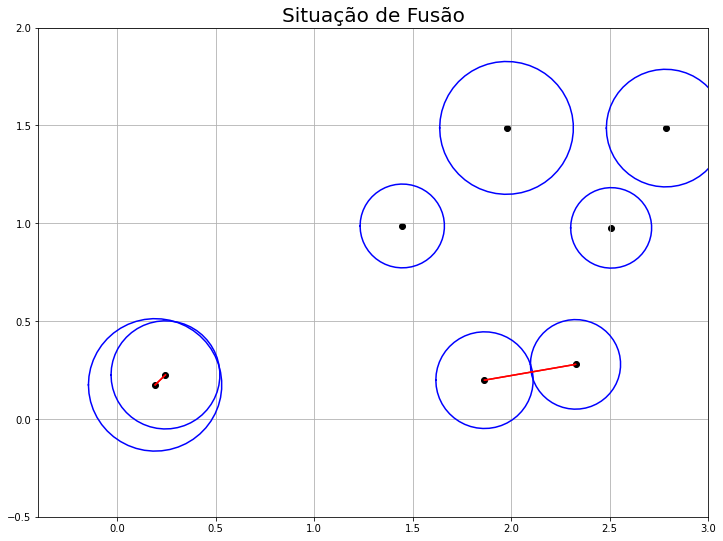

In [24]:
logs  = generate_log_list(8)
index = distances(logs)

create_plot("Situação de Fusão")
show(logs)
show_collisions(logs,index)
print((index<0.2).sum())

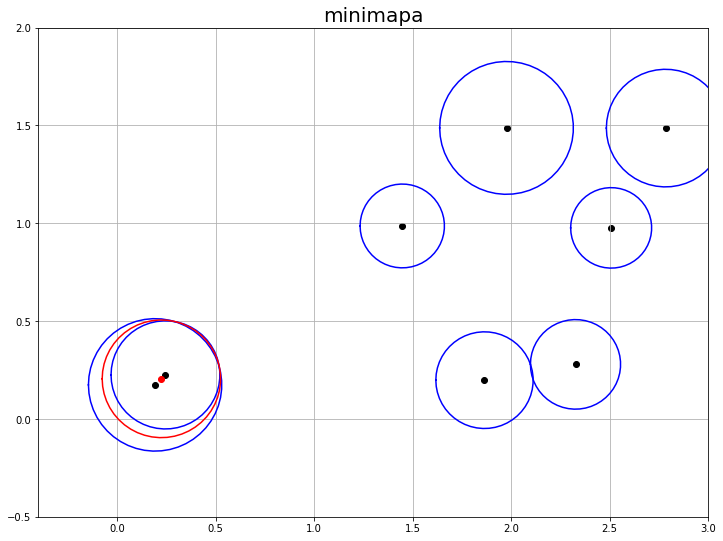

In [25]:
create_plot()
show(logs)
fuse_process(logs,index,threshold = 0.2)
index = distances(logs)


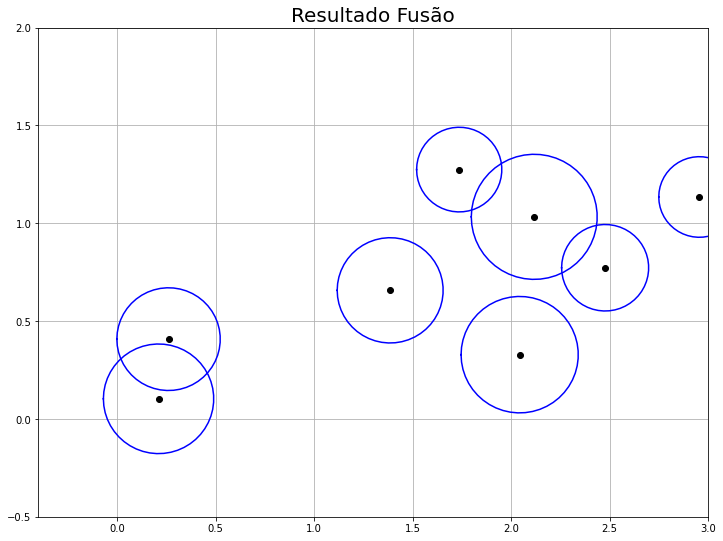

In [13]:
create_plot("Resultado Fusão")
show(logs)
fuse_process(logs,index,threshold = 0.2)
index = distances(logs)

## Reshape das toras

In [14]:
def reshape(logs,index,thresh):
    for i in range(len(logs)):
        for j in range(len(logs)):
            if i < j:
                if index[i,j]>thresh and index[i,j]<1:
                    d = ((logs[i].x-logs[j].x)**2+(logs[i].y-logs[j].y)**2)**0.5
                    erro = logs[i].r+logs[j].r - d
                    q1 = logs[i].q
                    q2 = logs[j].q
                    logs[i].r = logs[i].r-erro*q1/(q1+q2)
                    logs[j].r = logs[j].r-erro*q2/(q1+q2)

2


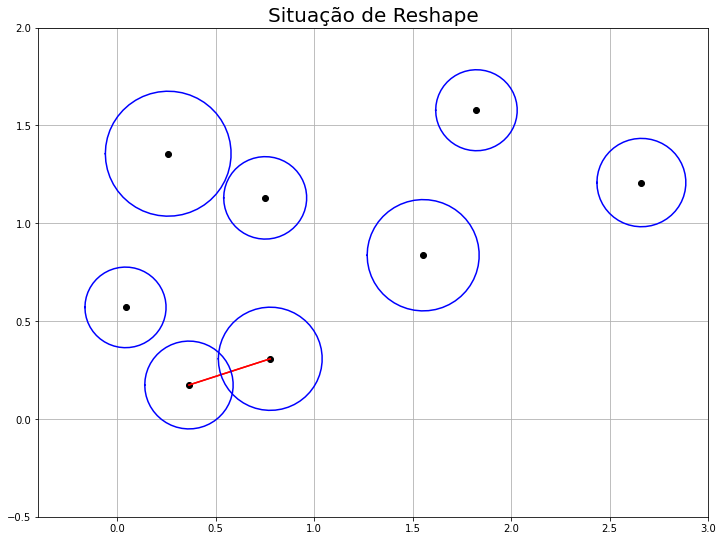

In [37]:
logs  = generate_log_list(8)
index = distances(logs)
create_plot("Situação de Reshape")
show_collisions(logs,index)
show(logs)
print(((index>0.8)*(index<1)).sum())

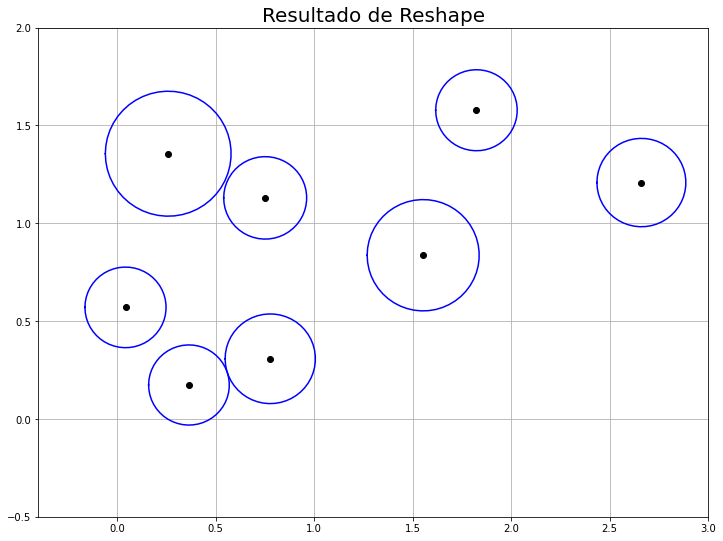

In [38]:
index = distances(logs)
create_plot("Resultado de Reshape")
reshape(logs,index,0.8)
index = distances(logs)
show_collisions(logs,index)
show(logs)

reshape(logs,index,0.8)

## Exclusão das toras

In [ ]:
r_thresh = 0.8
f_thresh = 0.2

def exclude(logs,index,r_thresh,f_thresh):
    logs_to_exclude = []
    for i in range(len(logs)-1,-1,-1):
        for j in range(len(logs)-1,-1,-1):
            if i>j:
                if index[i,j]<r_thresh and index[i,j]>f_thresh:
                    if logs[j].q>logs[i].q:
                        logs_to_exclude.append(i)
                    else:
                        logs_to_exclude.append(j)
    
    logs_to_exclude = list(set(logs_to_exclude))
    logs_to_exclude.sort()
    
    for i in logs_to_exclude[::-1]:
        logs.pop(i)
                

[[2.         3.03109342 1.04768457 2.83487986]
 [3.03109342 2.         3.7984001  0.93530796]
 [1.04768457 3.7984001  2.         3.72195565]
 [2.83487986 0.93530796 3.72195565 2.        ]]


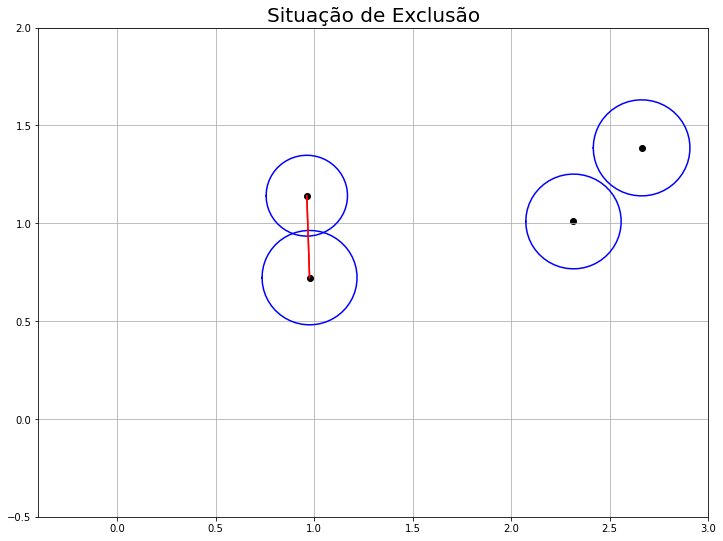

In [ ]:
logs  = generate_log_list()
index = distances(logs)

create_plot("Situação de Exclusão")
show(logs)
show_collisions(logs,index)
print(index)

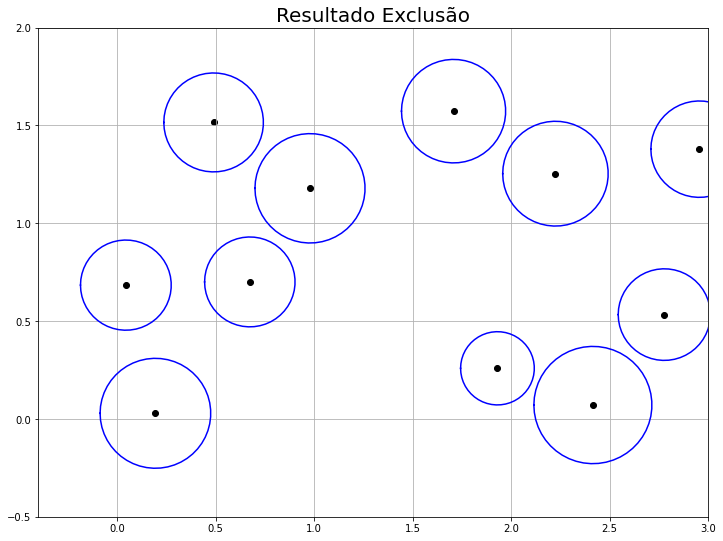

In [ ]:
create_plot("Resultado Exclusão")
exclude(logs,index,r_thresh,f_thresh)
index = distances(logs)

show(logs)
show_collisions(logs,index)
#print(index)

(15, 15)
15
(15, 15)
15
(16, 16)
16
(14, 14)
14
(14, 14)
14
(14, 14)
14
(15, 15)
15
(14, 14)
14
(15, 15)
15
(13, 13)
13
(13, 13)
13
(13, 13)
13
(13, 13)
13
(13, 13)
13
(14, 14)
14
(13, 13)
13
(14, 14)
14
(14, 14)
14
(13, 13)
13
(13, 13)
13
(13, 13)
13
(13, 13)
13
(12, 12)
12
(11, 11)
11
(11, 11)
11
(11, 11)
11
(10, 10)
10
(10, 10)
10
(10, 10)
10
(11, 11)
11
(10, 10)
10
(11, 11)
11
(10, 10)
10
(12, 12)
12
(11, 11)
11
(11, 11)
11
(10, 10)
10
(10, 10)
10
(11, 11)
11
(11, 11)
11
(12, 12)
12
(13, 13)
13
(13, 13)
13
(14, 14)
14
(13, 13)
13
(15, 15)
15
(13, 13)
13
(11, 11)
11
(12, 12)
12
(12, 12)
12
(12, 12)
12
(13, 13)
13
(13, 13)
13
(11, 11)
11
(11, 11)
11
(12, 12)
12
(11, 11)
11
(11, 11)
11
(12, 12)
12
(11, 11)
11
(12, 12)
12
(12, 12)
12
(12, 12)
12
(12, 12)
12
(11, 11)
11
(11, 11)
11
(13, 13)
13
(12, 12)
12
(12, 12)
12
(11, 11)
11


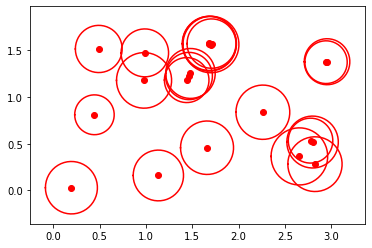

In [52]:
r_thresh = 0.9
f_thresh = 0.2

for i in range(70):    
    
    new_logs = generate_log_list(4)
    logs     +=new_logs
    index    = distances(logs)
    
    
    #create_plot("Frame "+str(i))
    #show_collisions(logs,index)
    #show(logs)
    #show(new_logs,c = "black")
    #plt.show()
    
    
    
    index = distances(logs)
    exclude(logs,index,r_thresh,f_thresh)
    
    
    #create_plot("Frame "+str(i)+" Exclusão")
    #show_collisions(logs,index)
    #show(logs)
    #plt.show()
    
    index = distances(logs)
    print(index.shape)
    print(len(logs))
    reshape(logs,index,r_thresh)
    
    
    #create_plot("Frame "+str(i)+" Reshape")
    #show_collisions(logs,index)
    #show(logs)
    #plt.show()
    
    index = distances(logs)
    fuse_process(logs,index,f_thresh)
    
    
    #create_plot("Frame "+str(i)+" Fusion")
    #show_collisions(logs,index)
    #show(logs)
    #plt.show()
    
        

In [22]:
collision
    intersecção entre as areas

fusion
    centros muito proximos
    
reshape
    area de intersecção pequena
    se a tora resultante for muito pequena, descarte a tora que ficaria muito tora pequena
    

exclusion
    preferencia por excluir novos
    

IndentationError: unexpected indent (3495300754.py, line 2)